## General Imports

In [12]:
import numpy
from matplotlib import pyplot
from tqdm import tqdm

## The Passive Sonar Equation

Notes from [this](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://apps.dtic.mil/sti/tr/pdf/ADA030034.pdf) MIT course.

The passive sonar equation is defined as:

$ SE = SL - PL - NL + AG - FT - DF_0$

Where the parameters are described as follows:

- `SE` - The `Signal Exess`. Normally specified as `0` and corresponds to the `Probability of detection` being $50\%$. Specified in `dB`
- `SL` - The `Signal Level` with the unit $dB/\sqrt{Hz} \,\, re \,\, 1 \mu \,\, Pa \,\, at \,\, 1m $
- `PL` - The `Propagation Loss` the signal shall experience
- `NL` - The `Noise Level` at the receiver
- `AG` - The `Array Gain` along its bore sight can also include `DI` the `Directivity Index` which account for loss due to receipt not along bore sight
- `DT` - The `Detection Threshold` is the signal level (above the noise floor) when the system decides there is a signal present
- `DF0` - `Operational Degradation` which is a catch all for losses in the sonar system

### Detection Threshold

This shall be defined as the radio os the signal power to the noise power in decibels:

$DT = 10log_{10}(\frac{S}{N_{0}})$

# Loss overview

There a multiple sources of loss in an acoustic system

These are shown in the diagram below:

``` mermaid

flowchart LR

AbsorptionLoss --> PropagationLoss
PropagationLoss --> SystemLoss

```

- AbsorptionLoss - Loss caused by the molecules through which the waves travel
- PropagationLoss - Loss caused by the spreading of wave energy as the propagation surface area increases
- SystemLoss - Loss induced by imperfect measurement systems


## System Loss

This describes the loss from the front end of the acoustic receiver - this is derived from a personal understanding and from online recourses.

```mermaid

flowchart TD

SystemLoss --> FrontEndLoss
SystemLoss --> MicrophoneLoss

```

- FrontEndLoss - The matching loss between the water and the device material


[The greater the difference in acoustic impedance between the two media, the greater the reflection and the smaller the transmission](https://phys.libretexts.org/Bookshelves/College_Physics/College_Physics_1e_(OpenStax)/17%3A_Physics_of_Hearing/17.07%3A_Ultrasound#:~:text=The%20intensity%20reflection%20coefficient%20for,1.&text=This%20result%20means%20that%20only,with%20the%20remaining%20being%20transmitted.). The simulation below demonstrates this. Transmission into the fluids generally results is "low" losses during transmission while there are large losses when transmitting between fluid and gas.

In [29]:
def CalculateReflectionCoefficient(p1, v1, p2, v2):
    '''
    Description:
    Determines the proportion fo the signal reflected back into the environment

    Inputs:
    p1 - Density of material 1 in kg/m3 
    v1 - Velocity of sound in material 1 in m/s
    p2 - Density of material 2 in kg/m3 
    v2 - Velocity of sound in material 2 in m/s

    Output:
    alpha - the reflection coefficient as a linear ratio
    '''

    z1 = p1*v1
    z2 = p2*v2

    alpha = (z2-z1)**2/(z1+z2)**2

    return alpha

if True: 
    # Parameters for Sea Water
    p_sea_water = 1020
    v_sea_water = 1450

    # Parameters for PVC
    p_pvc = 1330 
    v_pvc = 2395

    # Parameters for Mineral Oil
    p_oil = 700  
    v_oil = 1740 

    # Parameters for Air
    p_air = 1.225
    v_air = 343

    # What proportion of the signal is reflected back into the environment
    # from sea water to pvc
    reflection_coefficient_sea2pvc = CalculateReflectionCoefficient(p_sea_water, v_sea_water, p_pvc,v_pvc)
    # from pvc to oil
    reflection_coefficient_pvc2oil = CalculateReflectionCoefficient(p_pvc, v_pvc, p_oil,v_oil)
    # From pvc to air
    reflection_coefficient_pvc2air = CalculateReflectionCoefficient(p_pvc, v_pvc, p_air,v_air)
    # If there is the possibility of ignoring the boundary this will be the resulting equation
    reflection_coefficient_sea2oil = CalculateReflectionCoefficient(p_sea_water, v_sea_water, p_oil,v_oil)

    print("Proportion of signal not transmitted into next fluid for sea water to pvc:  " + str(reflection_coefficient_sea2pvc))
    print("Proportion of signal not transmitted into next fluid for pvc to oil: " + str(reflection_coefficient_pvc2oil))
    print("Proportion of signal not transmitted into next fluid for pvc to air: " + str(reflection_coefficient_pvc2air))
    print("Proportion of signal not transmitted into next fluid for sea water to oil: " + str(reflection_coefficient_sea2oil))

Proportion of signal not transmitted into next fluid for sea water to pvc:  0.1338301519680718
Proportion of signal not transmitted into next fluid for pvc to oil: 0.19961668813716085
Proportion of signal not transmitted into next fluid for pvc to air: 0.9994725048455554
Proportion of signal not transmitted into next fluid for sea water to oil: 0.009365244536940686


## Absorption Loss

### Theory

The original web source may be found [here](http://resource.npl.co.uk/acoustics/techguides/seaabsorption/physics.html). Noe that constant referred to as `A` are substituted in lower down on the page

The model of loss is shown in the diagram below:

```mermaid

flowchart TD

AbsorptionLoss --> BoricAcid
AbsorptionLoss --> MagnesiumSulphate
AbsorptionLoss --> PureWater

```

Loss is primarily comprised of:

- Boric Acid Contribution - Dominant at frequencies greater than 1MHz. Dependant on depth and temperature
- Magnesium Sulphate Contribution - Dependant on the relaxation frequency of the molecule which is in turn dependant on salinity and temperature. referred to as `f1` in the source
- Pure Water Contribution - Same as above but referred to as `f2`

### Absorbtion Models

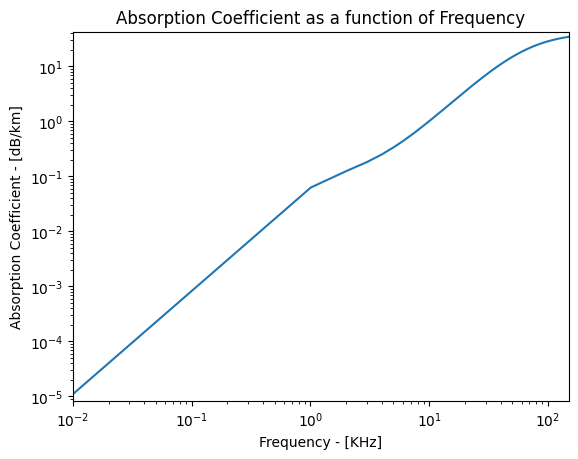

In [30]:
def CalculateBoricRelaxationFrequency(temperature, salinity):
    """
    Description:
    Calculates the relaxation frequency of boric acid in sea water

    Inputs:
    temperature - Temperature in degrees Celsius
    salinity - salinity of sea water in ppt

    Output:
    relaxationFrequency - relaxation frequency in hertz 
    """

    relaxationFrequency = 0.78*numpy.sqrt(salinity/35)*numpy.power(numpy.e, temperature/26)

    return relaxationFrequency

def CalculateMagnesiumSulphateRelaxationFrequency(temperature):
    """
    Description:
    Calculates the relaxation frequency of magnesium sulphate in sea water

    Inputs:
    temperature - Temperature in degrees Celsius

    Output:
    relaxationFrequency - relaxation frequency in hertz
    """

    relaxationFrequency = 42*numpy.power(numpy.e, temperature/17)

    return relaxationFrequency 

def CalculateBoricRelationCoefficient(frequency_of_interest, temperature, salinity, pH):
    """
    Description:
    Calculates the absorption coefficient of at a frequency of interest due to boric acid in dB/km

    Inputs:
    frequency_of_interest - Frequency at which relaxation in calculated
    temperature - Temperature in degrees Celsius
    salinity - Salinity of sea water in ppt
    ph - ph of sea water

    Output:
    relaxationCoefficient - absorption coefficient of at a frequency of interest (dB/km)
    """

    relaxationFrequency = CalculateBoricRelaxationFrequency(temperature, salinity)
    
    relaxationCoefficient = 0.106*numpy.power(numpy.e, (pH - 8)/0.56)*( (relaxationFrequency*numpy.power(frequency_of_interest,2)) / (numpy.power(relaxationFrequency,2) + numpy.power(frequency_of_interest,2)))

    return relaxationCoefficient

def CalculateMagnesiumSulphateRelationCoefficient(frequency_of_interest, temperature, salinity, depth):
    """
    Description:
    Calculates the absorption coefficient of magnesium sulphate at a frequency of interest in dB/km

    Inputs:
    frequency_of_interest - Frequency at which relaxation in calculated
    temperature - Temperature in degrees Celsius
    salinity - Salinity of sea water in ppt
    depth - Depth of sound propagation

    Output:
    relaxationCoefficient - absorption coefficient of at a frequency of interest (dB/km)
    """
    
    depth_in_km = depth/1000
    relaxationFrequency = CalculateMagnesiumSulphateRelaxationFrequency(temperature)

    relaxationCoefficient = 0.52*(1 + temperature/43)*(salinity/35)*(numpy.power(numpy.e, - depth_in_km/6))*( (relaxationFrequency*numpy.power(frequency_of_interest,2)) / (numpy.power(relaxationFrequency,2) + numpy.power(frequency_of_interest,2)))

    return relaxationCoefficient

def CalculateRelaxationCoefficient(frequency_of_interest, temperature, salinity, pH, depth):
    """
    Description:
    Calculates the absorption coefficient of magnesium sulphate and boric acid in dB/km

    Inputs:
    frequency_of_interest - Frequency at which relaxation in calculated (kHz)
    temperature - Temperature in degrees Celsius
    salinity - Salinity of sea water in ppt
    ph - ph of sea water
    depth - Depth of sound propagation

    Output:
    relaxationCoefficient - the absorption coefficient of magnesium sulphate and boric acid in dB/km
    """

    relaxationCoefficient = CalculateBoricRelationCoefficient(frequency_of_interest, temperature, salinity, pH) + CalculateMagnesiumSulphateRelationCoefficient(frequency_of_interest, temperature, salinity, depth)

    return relaxationCoefficient

# limit scope of contained variables
if True:

    min_search_frequency = 0.01 # kHz
    max_search_frequency = 150 # kHz
    frequency_of_interest = numpy.array([numpy.arange(min_search_frequency, max_search_frequency, 1)])
    temperature = 8
    salinity = 35
    pH = 8
    depth = 10 # meters
    
    absorption_coefficients = CalculateRelaxationCoefficient(frequency_of_interest, temperature, salinity, pH, depth) 

    fig, ax = pyplot.subplots()

    # setting axis scales to logarithmic
    ax.set_xscale('log')
    ax.set_yscale('log')

    # bounding axes
    ax.set_xlim(min_search_frequency, max_search_frequency)
    ax.set_ylim(numpy.min(absorption_coefficients)*0.75, numpy.max(absorption_coefficients)*1.25)

    # adding axis titles
    ax.set_xlabel("Frequency - [KHz]")
    ax.set_ylabel("Absorption Coefficient - [dB/km]")
    ax.set_title("Absorption Coefficient as a function of Frequency")

    ax.plot(frequency_of_interest[0,:], absorption_coefficients[0,:])

## Propagation Loss

This describes the boundaries defined by cylindrical and spherical spreading

### Propogation Models

#### Environmental

- Source level is the transmission level of the target
- Noise level is the ambient noise level of the environment

#### System

- Array gain is the gain of the multi-element array
- Detection index a constant as a function of pd and pfa
- Frames to Evaluate (ndl) are the number of recording periods to consider for detection

#### Model

- Propagation type - spherical or cylindrical
- absorption_coefficient - coefficient to calculate absorbtion loss

In [26]:

def SolveCylindricalPropogation(absorption_coefficient, signal_excess):
    """
    Description:
    Determines maximum detection distance for cylindrical spreading

    Inputs:
    absorption_coefficient - absorption coefficient of sea water
    signal_excess - the signal excess at the receiver input (dB)

    Output:
    max_cylindrical_distance - maximum detection distance in km
    """
        
    import sympy

    # define symbolic variables
    r, absorption_coefficient_sym = sympy.symbols('r absorption_coefficients_sym')

    # solve for range                                      
    equation = sympy.Eq( 10*sympy.log(r, 10) + absorption_coefficient_sym*sympy.log(r, 10), signal_excess)
    equation = equation.subs({absorption_coefficient_sym: absorption_coefficient})
    
    max_cylindrical_distance = numpy.float64(sympy.solve(equation, r))
    
    # scaling to km
    max_cylindrical_distance - max_cylindrical_distance*10e-3

    return max_cylindrical_distance

def SolveSphericalPropogation(absorption_coefficient, signal_excess):
    """
    Description:
    Determines maximum detection distance for spherical spreading

    Inputs:
    absorption_coefficient - absorption coefficient of sea water
    signal_excess - the signal excess at the receiver input (dB)

    Output:
    max_spherical_distance - maximum detection distance in km
    """
        
    import sympy

    # define symbolic variables
    r, absorption_coefficient_sym = sympy.symbols('r absorption_coefficients_sym')

    # solve for range               
    equation = sympy.Eq( 20*sympy.log(r, 10) + absorption_coefficient_sym*sympy.log(r, 10), signal_excess)
    equation = equation.subs({absorption_coefficient_sym: absorption_coefficient}) 

    max_spherical_distance = numpy.float64(sympy.solve(equation, r))

    # scaling to km
    max_spherical_distance = max_spherical_distance*10e-3

    return max_spherical_distance

def SolveMixedCylindricalSphericalPropogation(absorption_coefficient, signal_excess):
    """
    Description:
    Determines maximum detection distance for cylindrical spreading

    Inputs:
    absorption_coefficient - absorption coefficient of sea water
    signal_excess - the signal excess at the receiver input (dB)

    Output:
    max_cylindrical_distance - maximum detection distance in km
    """
        
    import sympy

    # define symbolic variables
    r, absorption_coefficient_sym = sympy.symbols('r absorption_coefficients_sym')

    # solve for range                                      
    equation = sympy.Eq( 15*sympy.log(r, 10) + absorption_coefficient_sym*sympy.log(r, 10), signal_excess)
    equation = equation.subs({absorption_coefficient_sym: absorption_coefficient})
    
    max_cylindrical_distance = numpy.float64(sympy.solve(equation, r))
    
    # scaling to km
    max_cylindrical_distance - max_cylindrical_distance*10e-3

    return max_cylindrical_distance

# Bringing It All Together

- Set system parameters
- Set environmental parameters

Will run and plot maximum detection distance as a function of signal frequency

Propagation modelling discussed [here](https://github.com/Sense-Scape/Documents/blob/main/Source/General/Acoustic%20Propogation%20-%20Ocean.md)

In [34]:
# Environmental
source_level = 138  # dBm
noise_level = 85 # dBm

# system parameters
array_gain = 0 # dBm
detection_index = 25 # taken from graph 9pd = 0.9, pfa = 0.010
collection_period = 1 # T
reviewed_periods = 1 # ndl
w = 1 # w from detection index

frames_to_evaluate = 0
min_frequency_of_interest = 1 # khz
max_frequency_of_interest = 100 # khz
step_frequency_of_interest = 1
frequency_of_interest = numpy.array(numpy.arange(min_frequency_of_interest, max_frequency_of_interest, step_frequency_of_interest)) # kHz

# model parameters
temperature = 12 # temperature of sea water
salinity = 35 # salinity of sea water
pH = 8 # pH of sea water
depth = 1 # meters


# Parameters for Sea Water
p_sea_water = 1020
v_sea_water = 1450
# Parameters for PVC
p_pvc = 1330 
v_pvc = 2395
# Parameters for Mineral Oil
p_oil = 700  
v_oil = 1740 
  
reflection_coefficient_sea2pvc = CalculateReflectionCoefficient(p_sea_water, v_sea_water, p_pvc,v_pvc)
reflection_coefficient_pvc2oil = CalculateReflectionCoefficient(p_pvc, v_pvc, p_oil,v_oil)
system_loss = 10*numpy.log10((1-reflection_coefficient_sea2pvc)*(1-reflection_coefficient_pvc2oil))

# setting up detection equation
signal_excess = source_level - noise_level - system_loss + array_gain + 5*numpy.log10(detection_index/(w*collection_period)) - numpy.log10(reviewed_periods)

# array to store max detection distances
max_detection_distances_spherical = numpy.array([])
max_detection_distances_cylindrical = numpy.array([])
max_detection_distances_mixed = numpy.array([])

# getting some progress counting information
progress_counter = 0
max_progress_count = len(frequency_of_interest)

# lets loop through all the frequencies of interest
for frequency in tqdm(frequency_of_interest):

    # calculate the absorbtion coefficient for this frequency
    absorption_coefficient = CalculateRelaxationCoefficient(frequency, temperature, salinity, pH, depth)

    # then solve for the max detection distance
    spherical_sol = SolveSphericalPropogation(absorption_coefficient, signal_excess)
    cylindrical_sol = SolveCylindricalPropogation(absorption_coefficient, signal_excess)
    mixed_sol = SolveMixedCylindricalSphericalPropogation(absorption_coefficient, signal_excess)

    # and store it
    max_detection_distances_spherical = numpy.append(max_detection_distances_spherical, spherical_sol)
    max_detection_distances_cylindrical = numpy.append(max_detection_distances_cylindrical, cylindrical_sol)
    max_detection_distances_mixed = numpy.append(max_detection_distances_mixed, mixed_sol)

# creating plot
fig, ax = pyplot.subplots()
ax.plot(frequency_of_interest, max_detection_distances_spherical, label='Spherical Spreading')
ax.plot(frequency_of_interest, max_detection_distances_cylindrical, label='Cylindrical Spreading')
ax.plot(frequency_of_interest, max_detection_distances_mixed, label='Mixed Spreading')

# bounding axes
# horizon @ 40m is 120 km
# horizon @ 1000m is 150 km 
# 370 is size of an Exclusive economic zone
ax.set_ylim(numpy.min(1), numpy.max(375))

# adding legend
ax.legend([])
ax.legend(loc='upper left')

# adding axis titles
ax.set_xlabel("Frequency of Interest - [KHz]")
ax.set_ylabel("Detection Range - [km]")
ax.set_title("Detection Range as a function of Frequency")

 21%|██        | 21/99 [00:05<00:20,  3.83it/s]